# Rat Sightings in New York City

The purpose of this project is to....

In [208]:
###GENERAL LIBRARIES####

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from census import Census
import datetime as datetime
import calendar


In [209]:
###IMPORTING & CLEANING DATA###

rat = "Rat_Sightings.csv"
rat_df = pd.read_csv(rat, low_memory=False)
rat_df['converted_date'] = pd.to_datetime(rat_df['Created Date'],infer_datetime_format=True)
rat_df.drop(rat_df[rat_df.Borough=='Unspecified'].index, inplace=True)
rat_df = rat_df[(rat_df['converted_date'] < '2018-01-01') ]
rat_df = rat_df [["Created Date", "Closed Date", "Location Type","Borough","Latitude",
                    "Longitude", "converted_date"]]

In [210]:
###CREATING SEASONS & MONTH/YEAR VARIABLES FOR GRAPHING###

rat_df['month'] = rat_df['converted_date'].dt.month
rat_df['Month'] = rat_df['month'].apply(lambda x: calendar.month_abbr[x])
rat_df['month_year'] = rat_df.converted_date.dt.to_period('M')
rat_df['season'] = ""
seasons = ['Winter', 'Winter', 'Spring', 'Spring', 'Spring', 'Summer', 'Summer', 'Summer', 'Fall', 'Fall', 'Fall', 'Winter']
month_to_season = dict(zip(range(1,13), seasons))
rat_df['season'] = rat_df['month'].replace(month_to_season)
clean_df = rat_df

In [211]:
###BASIC DESCRIPTIVES & FILE STRUCTURE###
print(clean_df.shape)
print(clean_df.describe())
print(clean_df.head())


#print(converted_date['month'].value_counts())
#print(converted_date['year'].value_counts())


(106640, 11)
            Latitude      Longitude          month
count  105895.000000  105895.000000  106640.000000
mean       40.739312     -73.934165       6.652138
std         0.082147       0.070378       3.049816
min        40.499502     -74.254437       1.000000
25%        40.679719     -73.966241       4.000000
50%        40.725009     -73.938222       7.000000
75%        40.815363     -73.899878       9.000000
max        40.912869     -73.701632      12.000000
             Created Date Closed Date            Location Type    Borough  \
0  01/01/2010 11:20:45 AM         NaN      1-2 Family Dwelling     QUEENS   
1  01/02/2010 12:50:36 AM         NaN      Commercial Building  MANHATTAN   
2  01/01/2010 03:05:37 PM         NaN  3+ Family Apt. Building     QUEENS   
3  01/01/2010 08:52:19 PM         NaN    Other (Explain Below)   BROOKLYN   
4  01/01/2010 04:14:27 PM         NaN  3+ Family Apt. Building      BRONX   

    Latitude  Longitude      converted_date  month Month month_ye

In [212]:
clean_df['Borough'].value_counts()

BROOKLYN         36433
MANHATTAN        27984
BRONX            21661
QUEENS           15474
STATEN ISLAND     5088
Name: Borough, dtype: int64

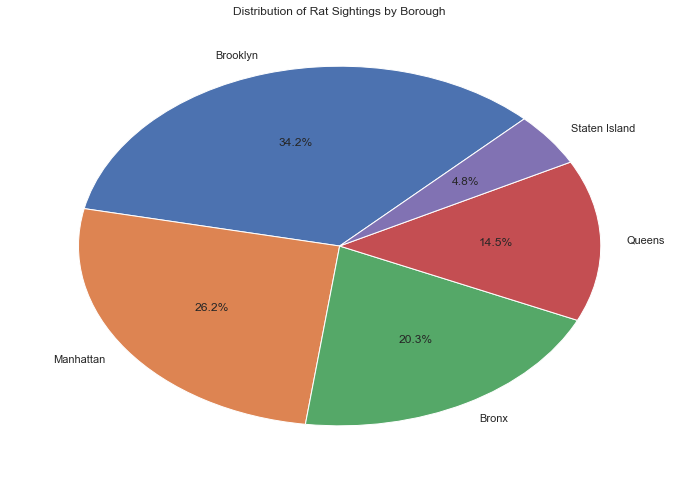

In [223]:
labels = ["Brooklyn", "Manhattan", "Bronx",'Queens', 'Staten Island']
sizes = clean_df['Borough'].value_counts()
plt.pie(sizes, labels=labels, startangle=45, autopct='%.1f%%')
plt.title('Distribution of Rat Sightings by Borough')
plt.show()

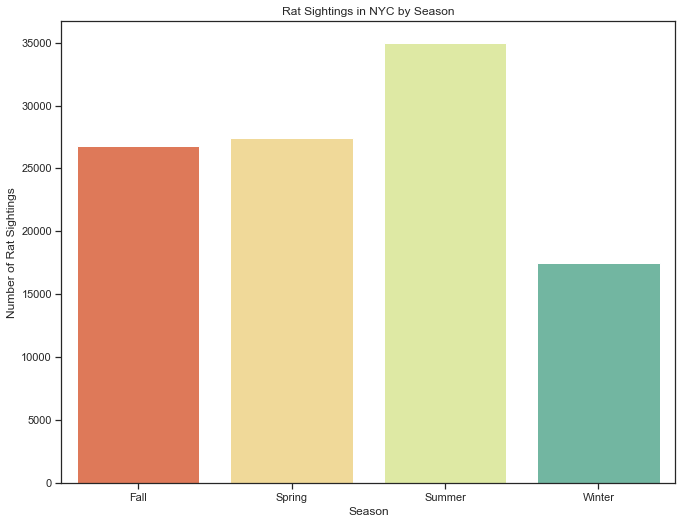

In [224]:
###SET UP DATA FOR COUNTS OF SIGHTINGS BY SEASON & CREATE GRAPH###

seasons = clean_df.groupby('season').agg('count')
source_data = pd.DataFrame(seasons).reset_index()

sns.set(style="whitegrid")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)
plt.title('Rat Sightings in NYC by Season')
fig = sns.barplot(x='season',y='month_year', data=source_data, palette = 'Spectral')
plt.xlabel("Season")
plt.ylabel("Number of Rat Sightings")

plt.show(fig)

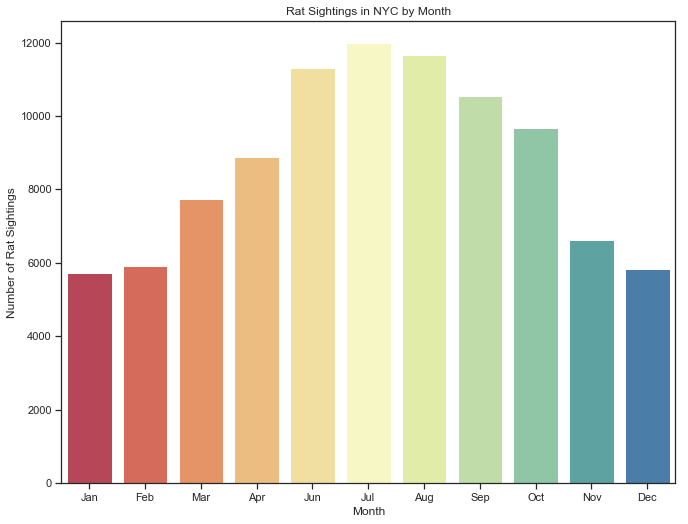

In [225]:
###SET UP DATA FOR MONTHLY COUNTS OF SIGHTINGS & CREATE GRAPH###
months = clean_df.groupby('Month').agg('count')
source_data = pd.DataFrame(months).reset_index()

sns.set(style="whitegrid")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)
plt.title('Rat Sightings in NYC by Month')
fig = sns.barplot(x='Month',y='month_year', data=source_data, palette = 'Spectral', 
                 order = ['Jan', 'Feb', 'Mar', 'Apr', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel("Month")
plt.ylabel("Number of Rat Sightings")
plt.show(fig)

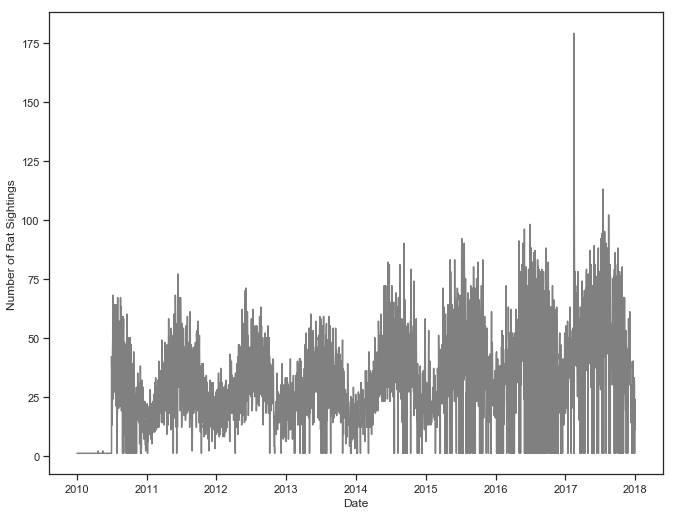

In [221]:
###SET UP DATA FOR DAILY COUNTS OF SIGHTINGS & CREATE GRAPH###
time_series = clean_df.groupby('converted_date').agg('count')
source_data = pd.DataFrame(time_series).reset_index()

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)
fig = sns.lineplot(x='converted_date', y='month', data=source_data, color="gray")
plt.xlabel("Date")
plt.ylabel("Number of Rat Sightings")

plt.show(fig)


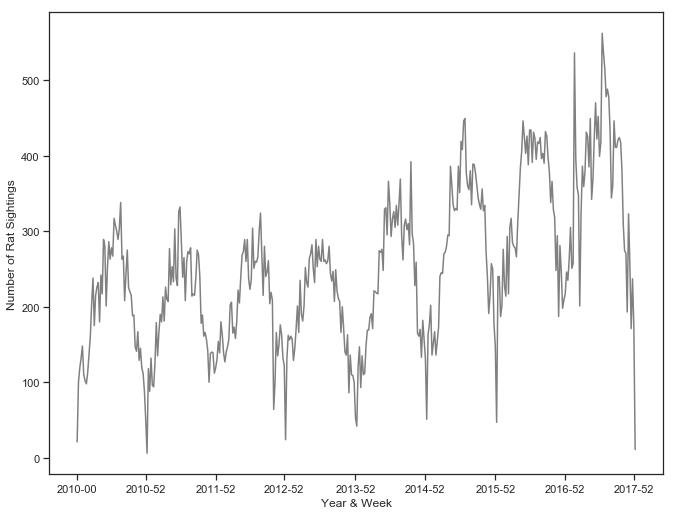

In [222]:
###SET UP DATA FOR WEEKLY COUNTS OF SIGHTINGS & CREATE GRAPH###
clean_df['Year-Week'] = clean_df['converted_date'].dt.strftime('%Y-%U')
time_series = clean_df.groupby('Year-Week').agg('count')
source_data = pd.DataFrame(time_series).reset_index()

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)
fig = sns.lineplot(x='Year-Week', y='month', data=source_data, color="gray")
plt.xlabel("Year & Week")
plt.ylabel("Number of Rat Sightings")
plt.setp(ax,xticks=[0,52, 105, 157, 211, 264, 317, 370, 422])
plt.show(fig)